## 实验目的

用给定的数据预测给定范围内的土质

## 实验简介

这是一个多分类的问题，土质与所在的坐标有关，并且结果需要用图像表示出来，易得可以适合用svc进行分类

## 数据描述

数据包括范围和点集，其中点集中的每个点给定坐标和该点的土质

数据散点图如下：

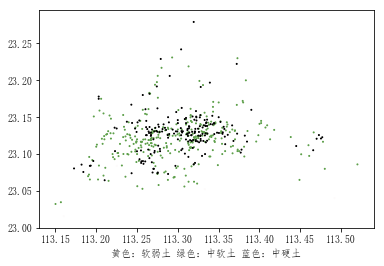

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import shapefile
from pylab import mpl

sfPoint = shapefile.Reader('data/钻孔1/钻孔1_Project.shp')

#read index of points
features = sfPoint.shapeRecords()[:]
index = []
for feature in features:
    tmp = feature.shape.__geo_interface__['coordinates']
    index.append(tmp)
index = np.array(index)
#read labels of points and translate to int
labels = []
dic = {b'\xc8\xed\xc8\xf5\xcd\xc1':3, b'\xd6\xd0\xc8\xed\xcd\xc1':2, b'\xd6\xd0\xd3\xb2\xcd\xc1':1}
size = len(sfPoint.records())
rec = sfPoint.records()
for i in range(size):
    labels.append(dic[rec[i][3]])
labels = np.array(labels)

# Plot the training points
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(index[:, 0], index[:, 1], c=labels, cmap=plt.cm.gist_earth, s=1, alpha=2)
mpl.rcParams['font.sans-serif'] = ['FangSong']
plt.xlabel("黄色：软弱土 绿色：中软土 蓝色：中硬土")

#save and show figure
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('./result/data.eps', format='eps', dpi=1000)
figure_fig.savefig('./result/data.jpg', format='jpg', dpi=1000)
plt.show()

## 主要任务

用SVM训练给定数据，预测给定范围内的坐标点的土质类型，转换为图片展示出来

## 主要代码解释

### 代码结构

1)导入相关库

2)从shp文件中读入数据，并整理其格式方便后续操作

3)计算给定范围坐标点的最大最小值，生成测试点的坐标即测试数据

4)训练svc模型，输入测试数据进行预测，根据预测结果进行调参

5)展示结果并保存图片

6)对训练结果进行准确性评分

### 主要代码及注释

#### 导入相关库

In [38]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import shapefile
from pylab import mpl
from sklearn.metrics import accuracy_score

#### 从shp文件中导入数据，转换为array结构

In [27]:
sfArea = shapefile.Reader('data/范围/范围.shp')
sfPoint = shapefile.Reader('data/钻孔1/钻孔1_Project.shp')

In [28]:
#read index of points
features = sfPoint.shapeRecords()[:]
index = []
for feature in features:
    tmp = feature.shape.__geo_interface__['coordinates']
    index.append(tmp)
index = np.array(index)

#read labels of points and translate to int
labels = []
dic = {b'\xc8\xed\xc8\xf5\xcd\xc1':3, b'\xd6\xd0\xc8\xed\xcd\xc1':2, b'\xd6\xd0\xd3\xb2\xcd\xc1':1}
size = len(sfPoint.records())
rec = sfPoint.records()
for i in range(size):
    labels.append(dic[rec[i][3]])
labels = np.array(labels)

#### 计算最大最小值，生成测试数据

In [29]:
#create test data
x_min, x_max = index[:, 0].min() - 0.02, index[:, 0].max() + 0.05
y_min, y_max = index[:, 1].min() - 0.04, index[:, 1].max() + 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max,0.003),np.arange(y_min, y_max, 0.003))

#### 训练svc模型，导入测试数据进行预测

In [30]:
#train model and predict
clf = SVC(C=100, gamma=10000)
clf.fit(index,labels)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

#### 用matplotlib画图

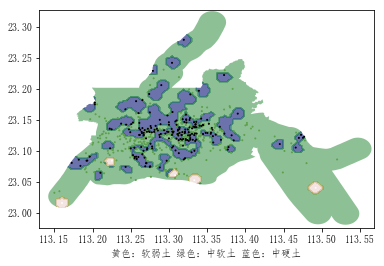

In [31]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
cont = plt.contourf(xx, yy, Z, cmap=plt.cm.gist_earth, alpha=0.60)
    
# Plot also the training points
plt.scatter(index[:, 0], index[:, 1], c=labels, cmap=plt.cm.gist_earth, s=1, alpha=2.5)

#translate the area to a path and clip
shape_rec = sfArea.shapeRecords()[-1]
vertices = []
codes = []
pts = shape_rec.shape.points
prt = list(shape_rec.shape.parts) + [len(pts)]
for i in range(len(prt) - 1):
    for j in range(prt[i], prt[i+1]):
        vertices.append((pts[j][0], pts[j][1]))
    codes += [Path.MOVETO]
    codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
    codes += [Path.CLOSEPOLY]
clip = Path(vertices, codes)
clip = PathPatch(clip, transform=ax.transData, edgecolor='k')
for col in cont.collections:
    col.set_clip_path(clip)

#set the limit of x y
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
    
#set labels
mpl.rcParams['font.sans-serif'] = ['FangSong']
plt.xlabel("黄色：软弱土 绿色：中软土 蓝色：中硬土")

#save result and show figure
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('./result/result.eps', format='eps', dpi=1000)
figure_fig.savefig('./result/result.jpg', format='jpg', dpi=1000)
plt.show()

#### 对预测精确度进行评分

In [43]:
#caculate the accuracy score
y_true = np.copy(labels)
y_pred = np.array(clf.predict(index[:]))
print("Accuracy: ", accuracy_score(y_true=y_true, y_pred=y_pred))

Accuracy:  0.8957528957528957


## 案例总结

本案例的难点在于：shp文件的读取 调参 切割边缘

解决方法

 - shp文件的读取：导入shapefile库进行读取，能够方便的读取点的坐标信息和属性
 
 - 调参：使用sklearn中的GridSearchCV函数，结合对结果图片效果的比较进行参数的选取
 
 - 切割边缘：从shp文件中读取形状数据，然后将形状中的点首尾相连，再用set_clip_path函数进行切割

## 参考资料

 - 《利用Python进行数据分析》
 - [Python超参数自动搜索模块GridSearchCV][1]
 - [Reads and writes ESRI Shapefiles][2]
 - [matplotlib basemap 绘制多边形区域曲线][3]
 - [支持向量机高斯核调参小结][5]

  [1]: https://www.cnblogs.com/nwpuxuezha/p/6618205.html
  [2]: https://github.com/GeospatialPython/pyshp
  [3]: https://blog.csdn.net/u011077672/article/details/77753300
  [5]:https://www.cnblogs.com/pinard/p/6126077.html